# Predição da Nota do Enem 2016 - Semana 8
**Por**: Kaike Wesley Reis

## Módulos

In [61]:
# Misc
import warnings
from time import sleep

# Manipulação de Dados
import pandas as pd
import numpy as np

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Análise de dados faltantes
import missingno as msno

# Evitar bugs para skopt usando sklearn > 0.23.1
from numpy.ma import MaskedArray
import sklearn.utils.fixes
sklearn.utils.fixes.MaskedArray = MaskedArray

# Modelagem
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from scipy import stats

# Comandos do notebook
warnings.filterwarnings('ignore')
%matplotlib inline

# Pré-processamento

## Importação dos dados

In [2]:
# Importação
train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv')

## Avaliar quais colunas existem no conjunto de treino e teste

In [3]:
print('No conjunto de treino existem',len(train.columns),'e no conjunto de teste existem',len(test.columns),'colunas.')

No conjunto de treino existem 166 e no conjunto de teste existem 47 colunas.


## Emparelhamento das colunas dos datasets (treino e teste)
Não vale a pena usar colunas que **não existem** no conjunto de teste para treinar o modelo, pois não teremos como prever o resultado final com elas.

In [4]:
cols = ['NU_NOTA_MT'] + list(test.columns)
train = train[cols]

## Criar coluna para predição no conjunto de teste

In [5]:
test['NU_NOTA_MT'] = np.nan

## Análise de valores faltantes

### (1) Fazer um overview da quantidade de valores faltantes para ambos os conjuntos

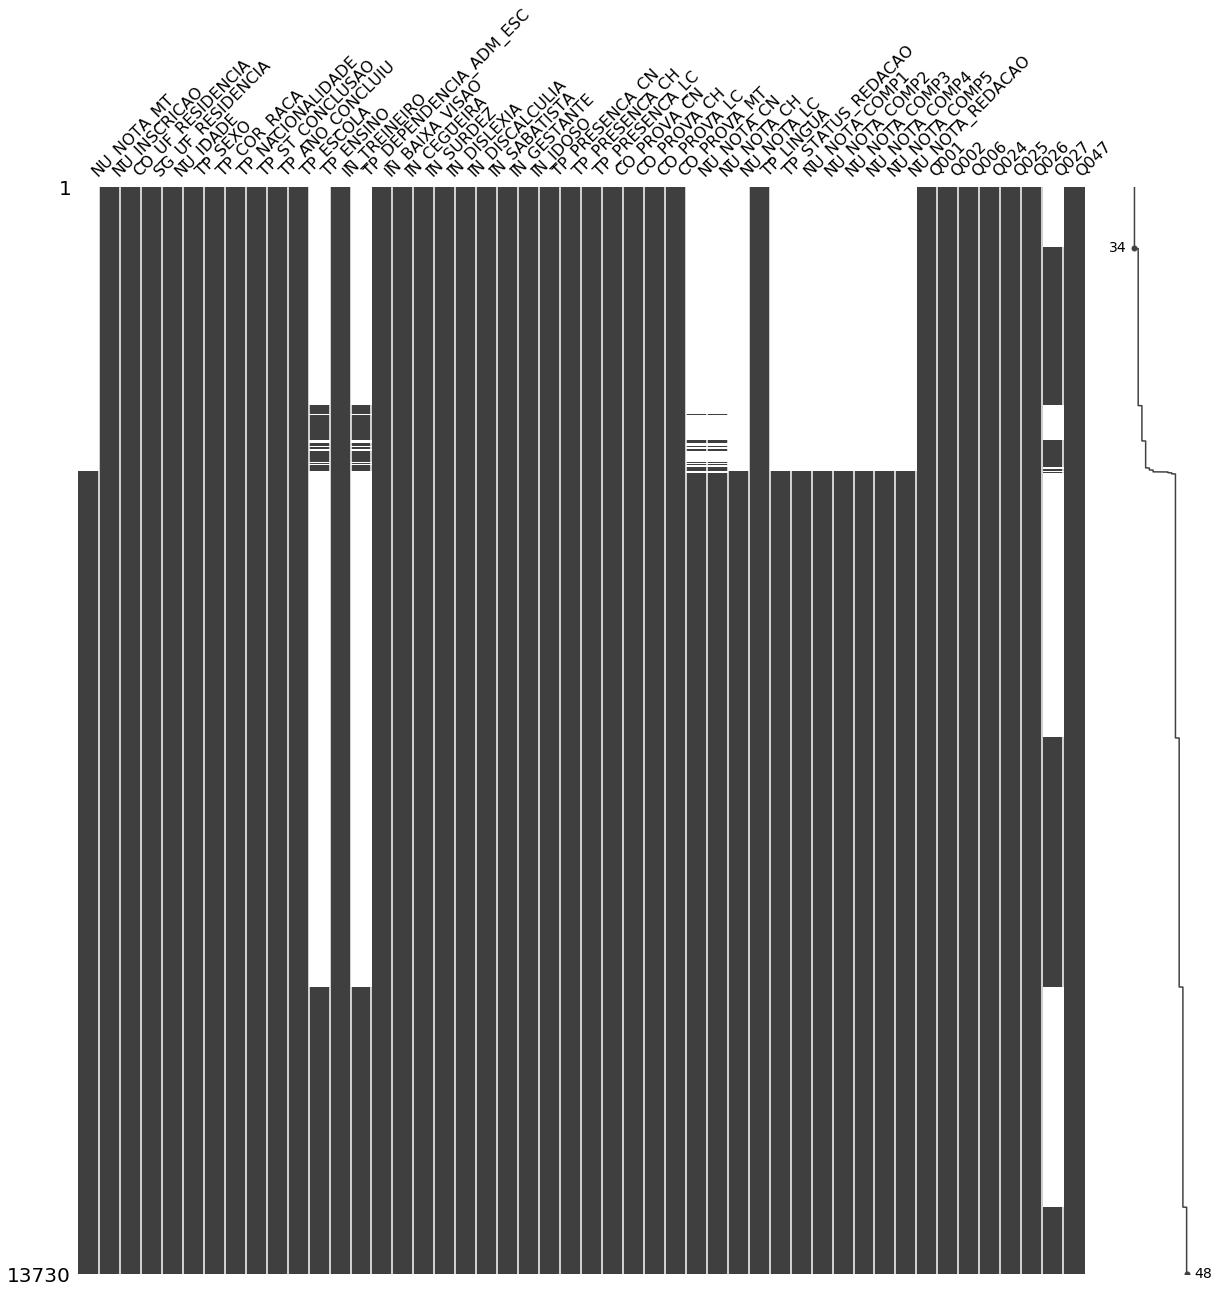

In [6]:
# Nullity Matrix para conjunto de treinamento
msno.matrix(train, sort='ascending', figsize=(20, 20));

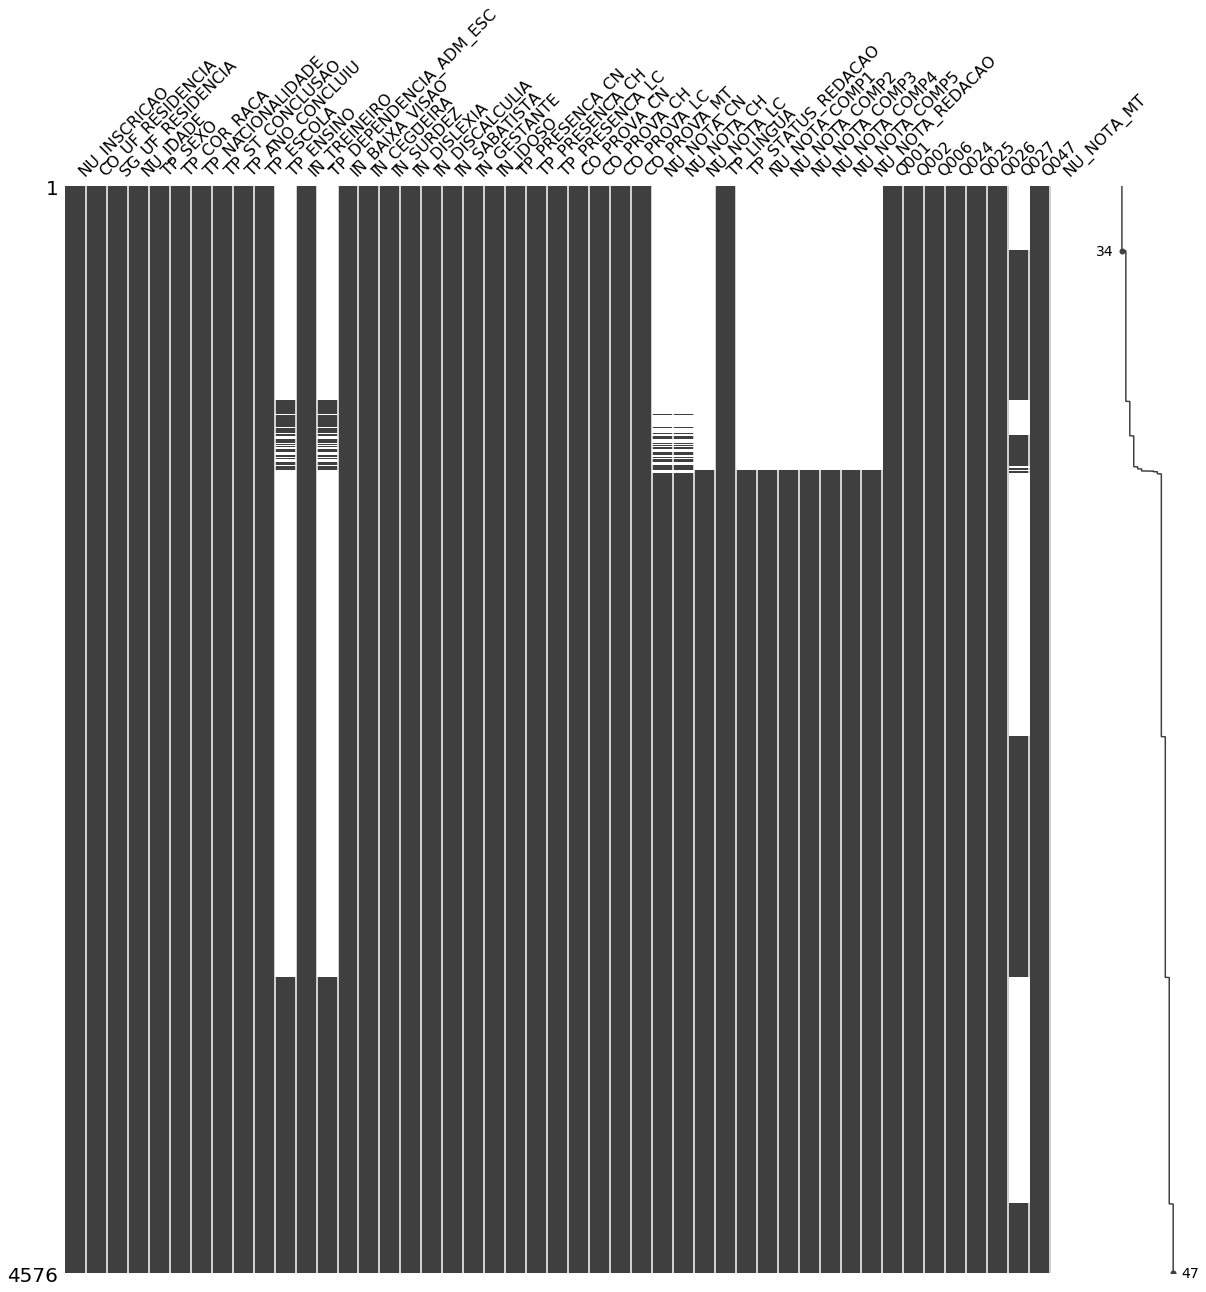

In [7]:
# Nullity Matrix para conjunto de teste
msno.matrix(test, sort='ascending', figsize=(20, 20));

Colocando esses gráficos em % podemos entender melhor a quantidade real de valores faltantes por coluna:

In [8]:
def plot_nan_porcentagem_por_coluna(df):
    # Cria dataset auxiliar
    nan_per_column = pd.DataFrame(df.isna().sum(),columns=['nanValues']).reset_index()
    # Calcular % de NaN  para cada feature
    for i in range(0,len(nan_per_column)):
        nan_per_column.loc[i, 'nanValuesPct'] = 100*round(nan_per_column.loc[i, 'nanValues']/len(df),3)
    # Manter apenas no dataset auxiliar as variaveis que apresentem NaN % acima de um valor
    nan_per_column = nan_per_column[nan_per_column['nanValuesPct'] > 0]
    
    # Plot
    plt.figure(figsize=(30,15))
    sns.barplot(y="index", x="nanValuesPct", data=nan_per_column)
    plt.ylabel('Variáveis', fontsize=20)
    plt.xlabel('% Faltante', fontsize=20)
    plt.title('Gráfico em % de valores faltantes', fontsize=30)
    plt.yticks(fontsize=15)
    plt.xticks([0,10,20,30,40,50,60,70,80,90,100], fontsize=15)

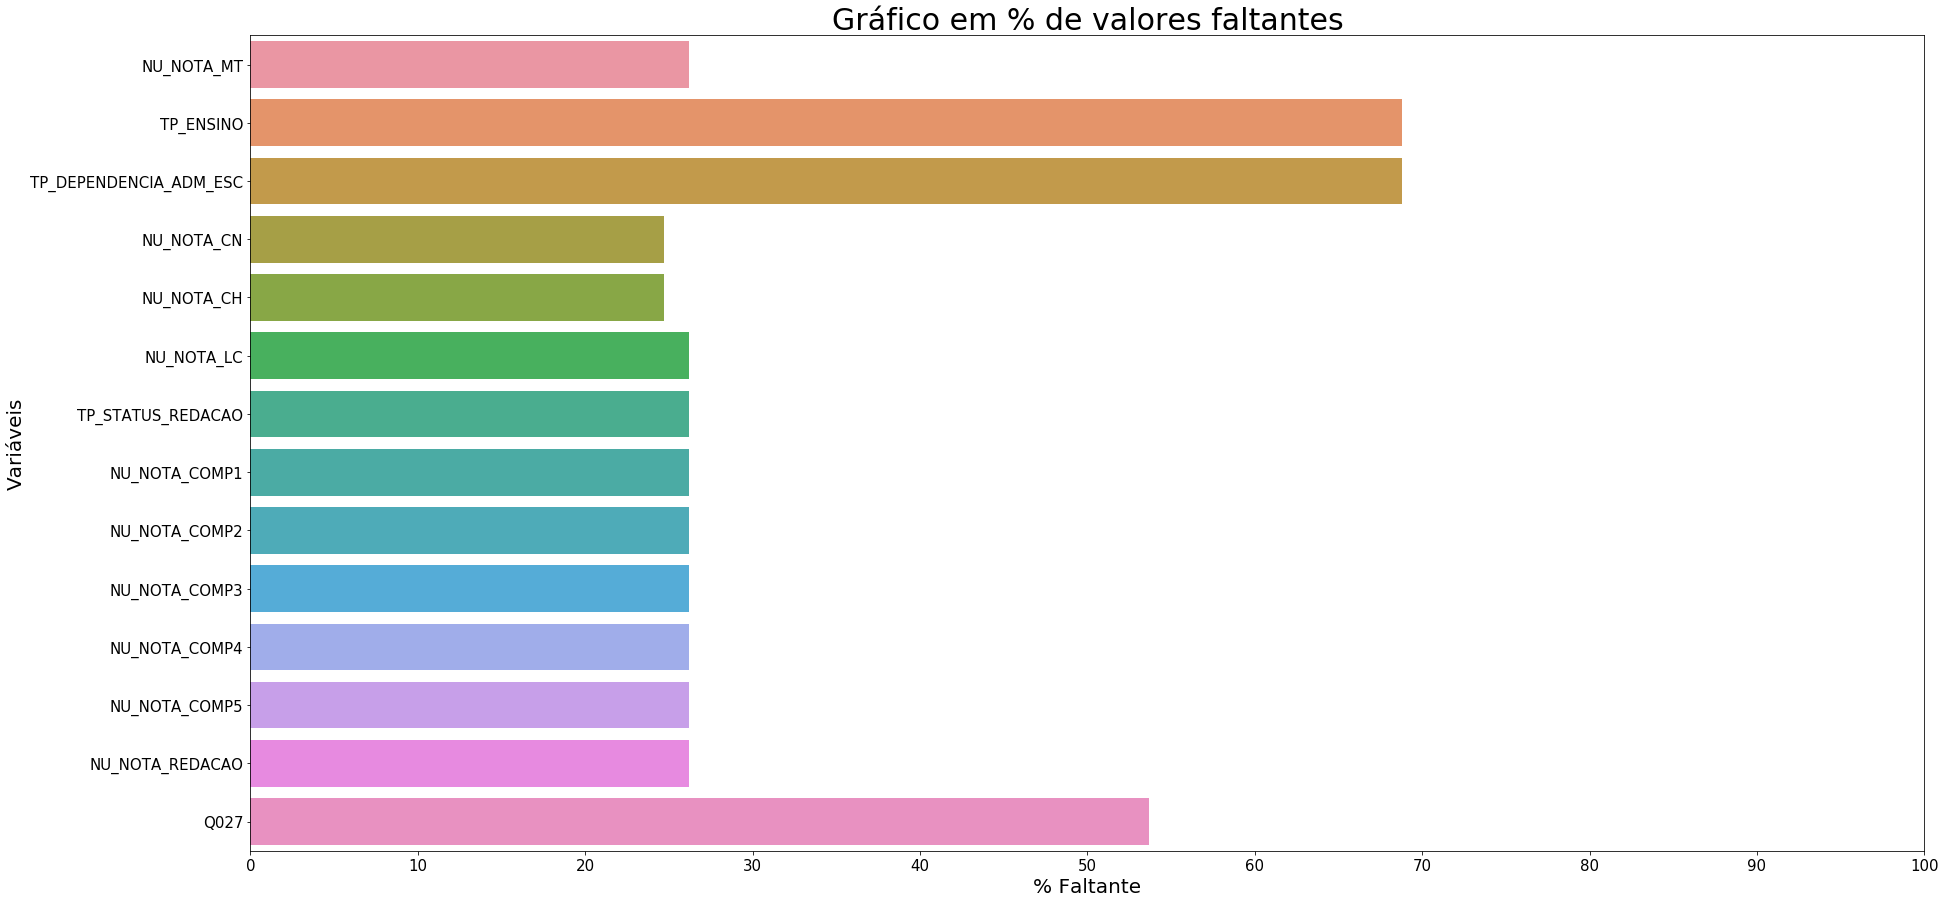

In [9]:
# Gráfico de NaN para treino
plot_nan_porcentagem_por_coluna(train)

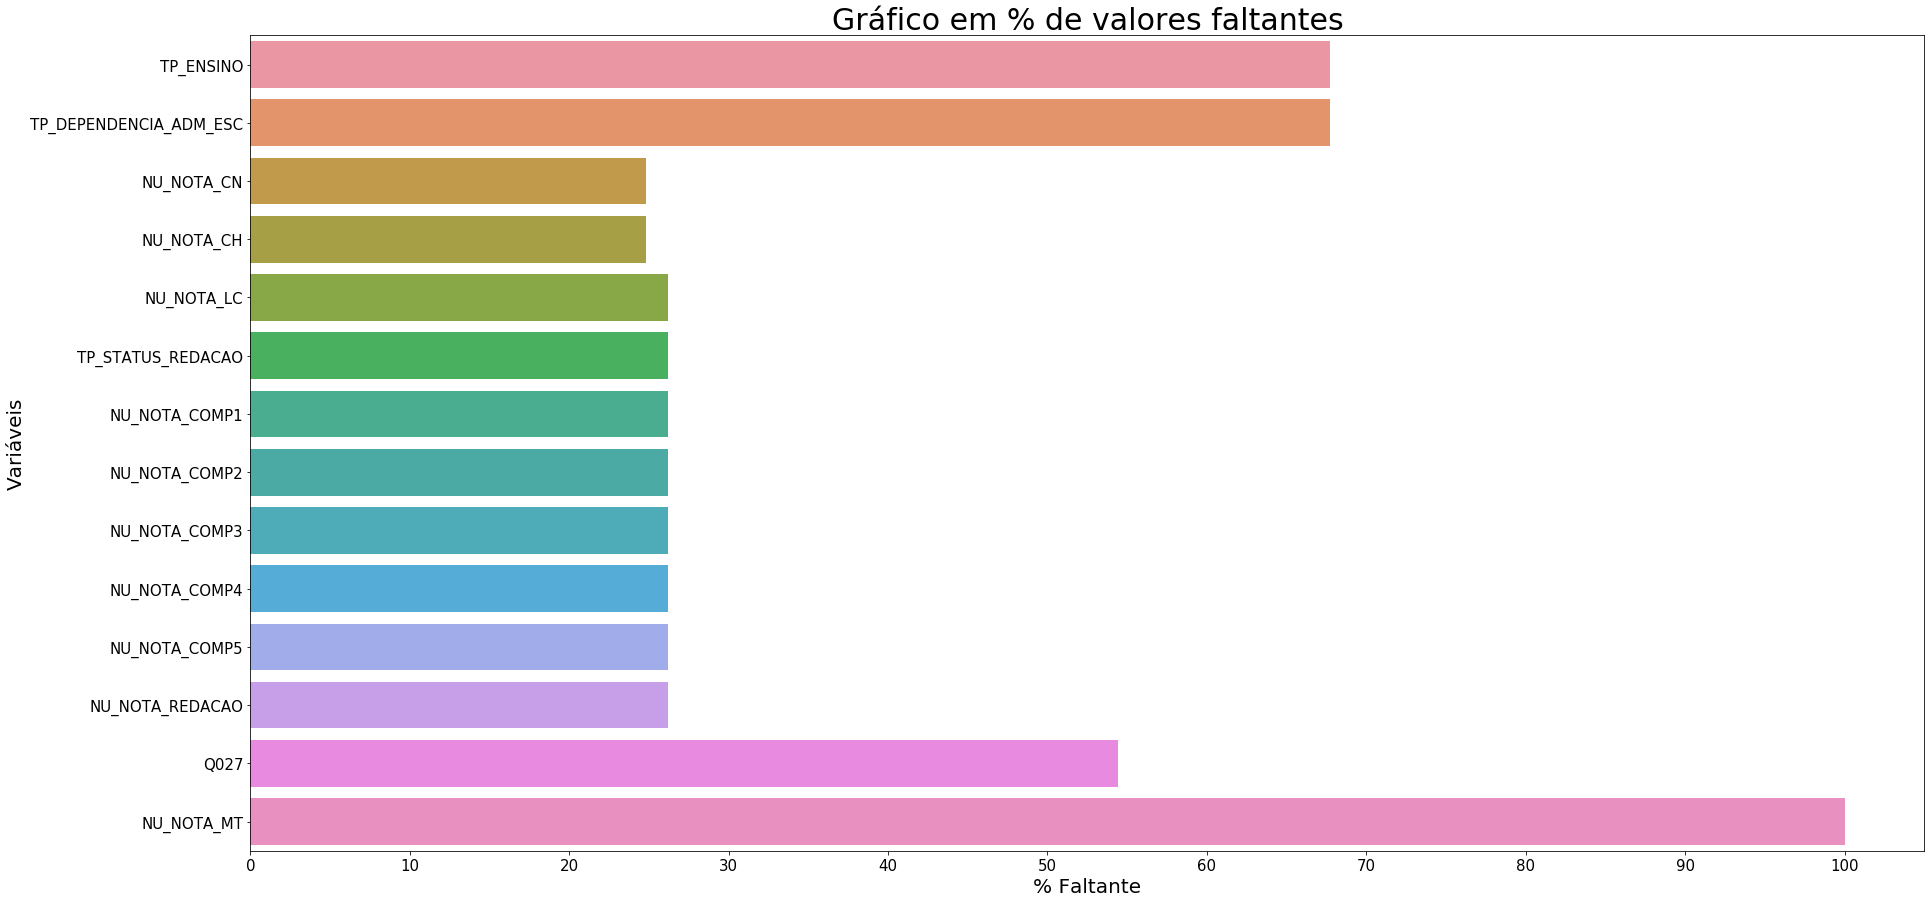

In [10]:
# Gráfico de NaN para teste
plot_nan_porcentagem_por_coluna(test)

### Comentário
Vemos que `Q027`, `TP_ENSINO` e `TP_DEPENDENCIA_ADM_ESC` apresentam mais de 50% de valores faltantes em ambos os datasets. Por se tratarem de variáveis de cunho pessoal, categóricas com grande quantidade faltante não acredito que seja interessante trabalhar com elas:

In [11]:
# Remover colunas que não irei continuar trabalhando
train.drop(axis=1, inplace=True, columns=['Q027','TP_ENSINO','TP_DEPENDENCIA_ADM_ESC'])
test.drop(axis=1, inplace=True, columns=['Q027','TP_ENSINO','TP_DEPENDENCIA_ADM_ESC'])

## (2) Correção (eliminação) dos valores faltantes em ambas as bases de dados
Antes de qualquer tipo de imputação a partir de análise matemática, irei realizar uma imputação mais subjetiva a partir das variáveis de presença na prova: `TP_PRESENÇA_CN`, `TP_PRESENÇA_CH` e `TP_PRESENÇA_LC`.

Dando um rápido overview, os dias de provas do ENEM 2016 eram divididos em:
- **1º Dia**: Ciências Humanas e suas Tecnologias (CH) e Ciências da Natureza e suas Tecnologias (CN)
- **2º Dia**: Matemática e suas Tecnologias (MT), Linguagens, Códigos e suas Tecnologiasn (LC) e Redação

Logo, com essas variáveis de presença, podemos avaliar se o estudante estava presente na prova e fazer algumas imputações a partir desse conhecimento. 

Para a construção do meu modelo, irei optar por excluir do conjunto de treinamento aqueles estudantes que faltaram pelo menos o **2º Dia**. Além disso, farei uma "predição" manual no conjunto de teste seguindo essa mesma ideia: caso o estudante não apresente presença no **2º Dia**, automaticamente sua nota será zero.

**OBS**: Será considerado que `TP_PRESENÇA_LC` represente a presença no **2º Dia** e `TP_PRESENÇA_CN` no **1º Dia**.

### (2.1) - "Predição" manual da variável `NU_NOTA_MT` no conjunto de teste

Inserir zero automaticamente no conjunto de teste para pessoas que faltaram ou foram eliminadas na prova de Linguagem e Códigos (eliminação implica na invalidação da prova daquele dia).

In [12]:
# Inserir zero para esses estudantes
test.loc[(test['TP_PRESENCA_LC'] == 0)|(test['TP_PRESENCA_LC'] == 2), 'NU_NOTA_MT'] = 0

### (2.2) - Tratamento de valores faltantes no conjunto de treinamento

#### (2.2.1) Quem ficou ausente OU eliminado no 2º dia será retirado do conjunto de treinamento
Não contribui para as notas de matemática

In [13]:
# Tamanho atual de amostras no conjunto de treinamento
len(train)

13730

In [14]:
# Quantidade de amostras que seguem esse padrao para eliminacao
len(train[(train['TP_PRESENCA_LC'] == 0)|(train['TP_PRESENCA_LC'] == 2)])

3597

In [15]:
# Remover amostras dos estudantes ausentes no 2 dia (apenas 1 é válido)
train = train[(train['TP_PRESENCA_LC'] == 1)]

In [16]:
# Resetar index
train.index = range(0, len(train))

Como removi uma grande quantidade de valores faltantes do conjunto de treinamento, vou avaliar novamente a quantidade de valores faltantes para avaliar o impacto dessa decisão:

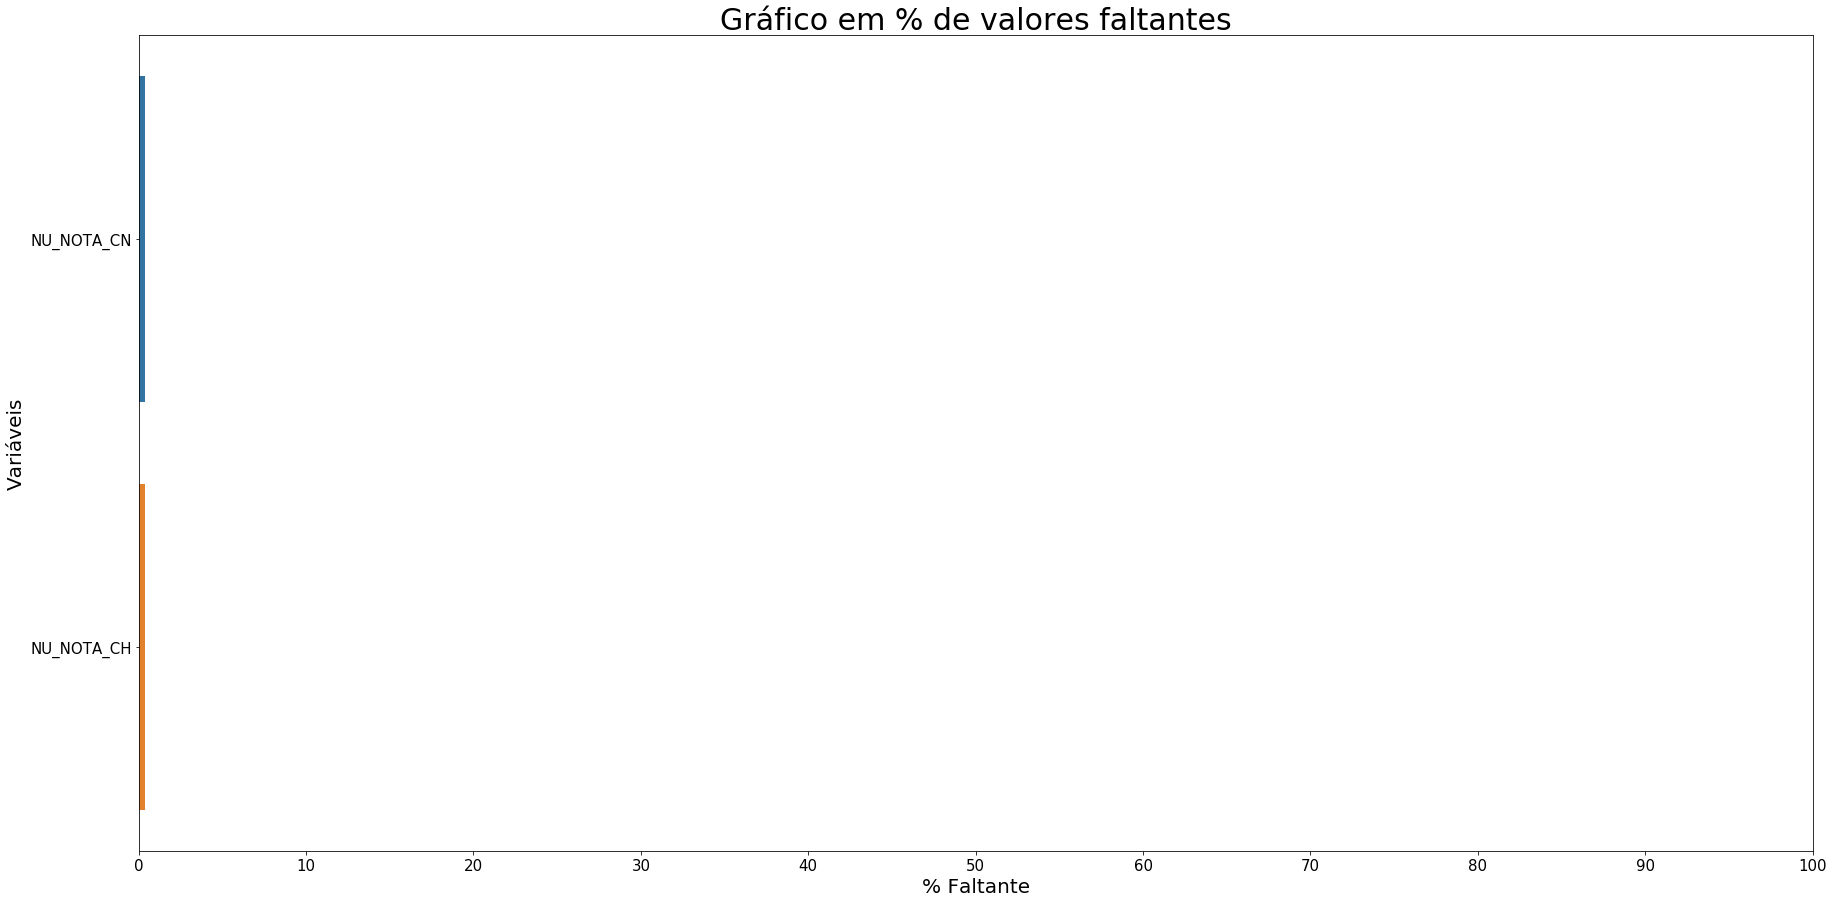

In [17]:
# Gráfico de NaN para treino
plot_nan_porcentagem_por_coluna(train)

Tivemos um resultado muito interessante: Aparentemente boa parte dos valores faltantes no conjunto de treinamento estava relacionado as pessoas que ficaram ausente ou foram eliminadas no **2º Dia**! De qualquer forma, preciso lidar com algumas amostras faltantes referente as notas de provas do **1º Dia**. Irei avaliar isso na próxima parte.

#### (2.2.2) Avaliação e remoção dos valores faltantes em outras notas de prova

In [18]:
# Verificar se os valores ausentes para ambas as notas ocorreram para os mesmos alunos
train[pd.isna(train['NU_NOTA_CN']) == True].index == train[pd.isna(train['NU_NOTA_CH']) == True].index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

Sim, ocorreu! Vamos analisar as seguintes hipóteses:
- **A - Os estudantes eram treineiros e queriam apenas testar suas habilidades no segundo dia**
- **B - Eles estiveram de alguma forma no segundo dia, mesmo não indo no primeiro**

Vamos ver rapidamente a primeira hipótese (como são poucos dados, uma análise visual será realizada):

In [19]:
# Hipótese A e B
train.loc[pd.isna(train['NU_NOTA_CN']) == True, ['TP_PRESENCA_LC','TP_PRESENCA_CN','TP_PRESENCA_CH',
                                                 'NU_NOTA_MT','NU_NOTA_LC','NU_NOTA_CH','NU_NOTA_REDACAO','IN_TREINEIRO']]

,TP_PRESENCA_LC,TP_PRESENCA_CN,TP_PRESENCA_CH,NU_NOTA_MT,NU_NOTA_LC,NU_NOTA_CH,NU_NOTA_REDACAO,IN_TREINEIRO
319,1,2,2,0.0,0.0,NaN,680.0,0
736,1,0,0,445.4,435.4,NaN,320.0,0
1213,1,0,0,397.6,492.1,NaN,500.0,0
1315,1,0,0,466.8,454.2,NaN,200.0,1
1318,1,0,0,329.0,374.4,NaN,340.0,0
1345,1,0,0,381.1,373.6,NaN,580.0,1
2032,1,0,0,454.5,402.7,NaN,500.0,0
2168,1,0,0,472.6,575.8,NaN,440.0,0
2792,1,0,0,461.2,496.2,NaN,640.0,0
3098,1,0,0,409.3,536.0,NaN,460.0,0


A **hipótese A** não se sustenta tanto, percebemos que esses valores faltantes são referentes as pessoas que faltaram ou foram desclassificadas de alguma forma na prova. Vamos avaliar agora a **hipótese B** para ver se essas pessoas estiveram presentes no segundo dia: A **hipótese B** é a mais correta com algumas ressalvas: algumas pessoas com notas faltantes no primeiro dia além de ter faltado, podem também ter sido eliminadas.

Portanto, como elas possuem notas no segundo dia será feito a imputação de zero nos valores faltantes e assim acabando com os missings:

In [20]:
# Zero para as notas de CN
train.loc[pd.isna(train['NU_NOTA_CN']) == True,'NU_NOTA_CN'] = 0

In [21]:
# Zero para as notas de CH
train.loc[pd.isna(train['NU_NOTA_CH']) == True,'NU_NOTA_CH'] = 0

#### (2.2.3) Avaliar notas zero na prova de matemática
Vamos avaliar em foco os alunos que tomaram zero nessa prova para evitar qualquer tipo de ruído no conjunto de treinamento:

In [22]:
# Analisar in locus os estudantes com nota zero
train.loc[train['NU_NOTA_MT']==0,['NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_REDACAO','TP_PRESENCA_LC','TP_PRESENCA_CN']]

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_REDACAO,TP_PRESENCA_LC,TP_PRESENCA_CN
84,0.0,0.0,0.0,0.0,1,1
319,0.0,0.0,0.0,680.0,1,2
2538,366.6,375.0,394.2,0.0,1,1
2790,438.1,506.2,375.9,360.0,1,1
3628,493.8,497.0,0.0,540.0,1,1
5431,471.2,565.2,0.0,560.0,1,1
5603,422.4,509.0,546.4,500.0,1,1
6211,457.8,366.9,0.0,360.0,1,1
8559,434.9,381.7,0.0,340.0,1,1
10041,0.0,326.2,0.0,400.0,1,1


Podemos considerar esses estudantes como *outliers*, pois apresentam notas regulares porém em algumas provas simplesmente zeraram. Além disso, no geral suas notas foram baixas.

Essas amostras serão eliminadas do banco de dados, pois toda a imputação de valor zero já foi realizada e a sua existência pode levar os modelos a resultados distoantes.

In [23]:
# Eliminar outliers (caso seja necessário)
train = train[train['NU_NOTA_MT'] != 0]

In [24]:
print('Tamanho amostral do conjunto de treinamento:',len(train),'amostras.')

Tamanho amostral do conjunto de treinamento: 10123 amostras.


### (2.3) Tratamento de valores faltantes no conjunto de teste

A ideia da análise de valores faltantes seguirá o mesmo raciocínio da etapa 2.2 com o conjunto de treinamento. Mas antes, vamos relembrar a tabela de valores faltantes do conjunto de teste:

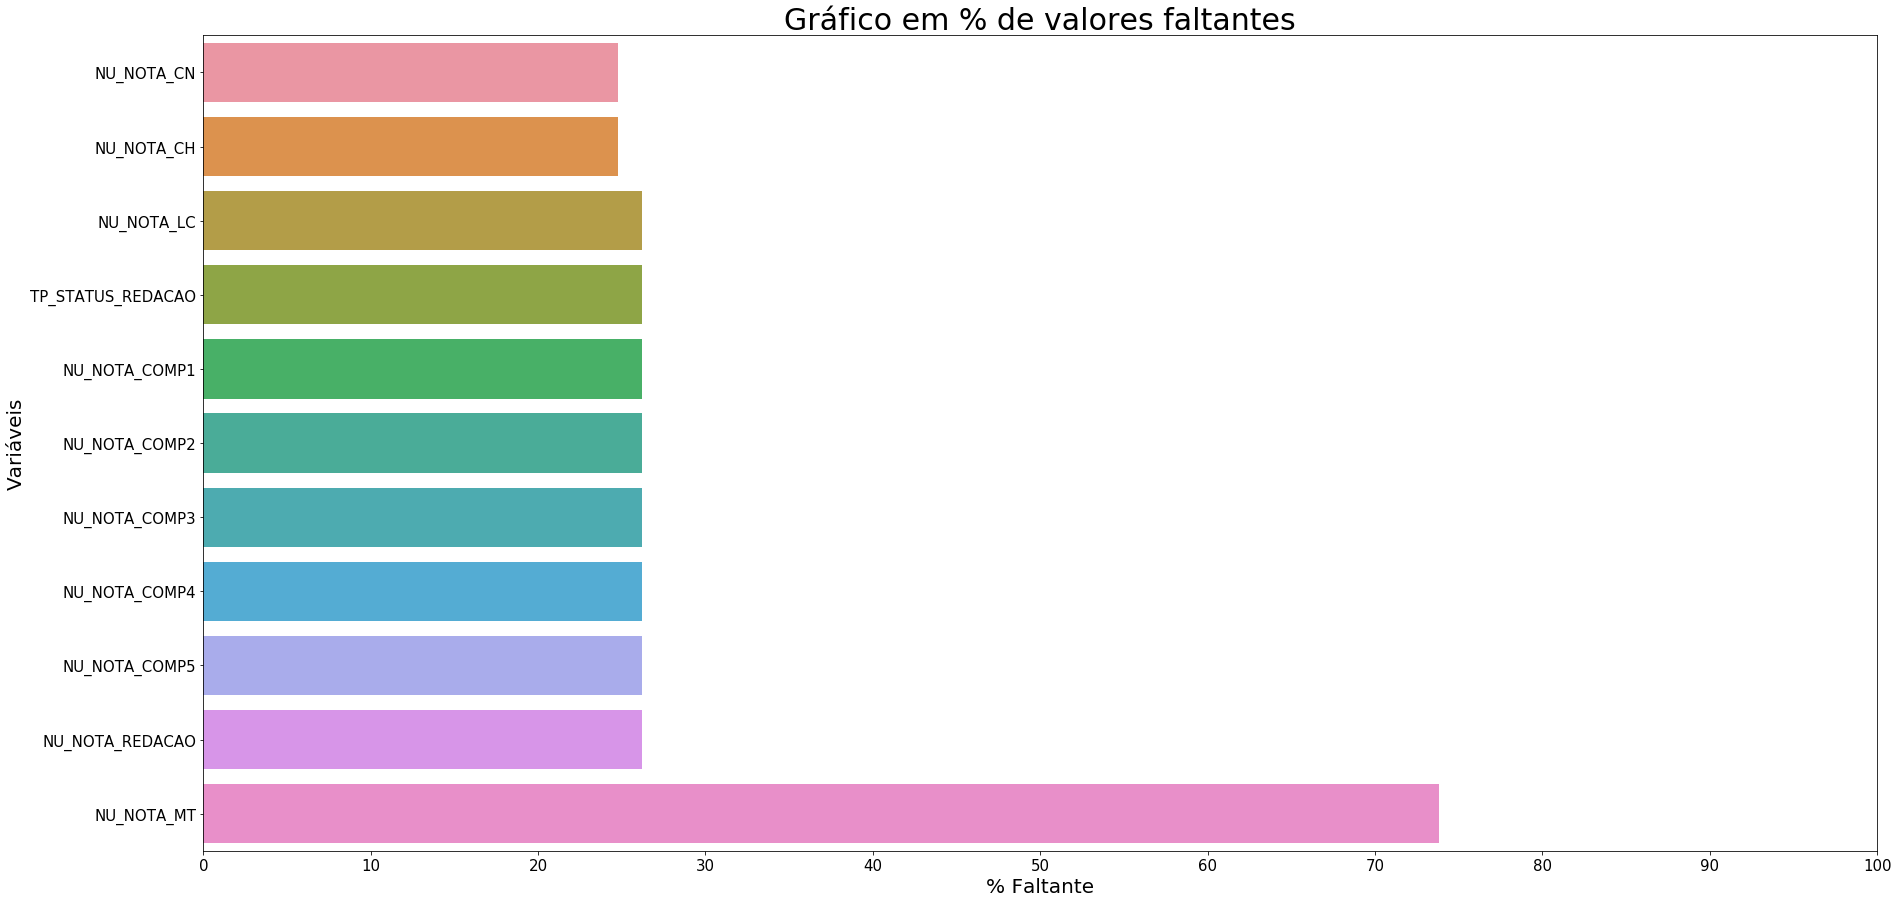

In [25]:
# Gráfico de NaN para teste
plot_nan_porcentagem_por_coluna(test)

Como esperado, aparentemente existe um padrão nesses valores faltantes (note que o desafio tem o objetivo de prever `NU_NOTA_MT`, por isso a mesma é a mais faltante). Diferente do conjunto de treinamento, eu não tenho a liberdade de excluir amostras logo é necessário **fazer imputação em todas essas amostras**.

#### (2.3.1) Quem ficou ausente em qualquer dia receberá zero automaticamente
- Ausente no primeiro dia `(TP_PRESENCA_CN == 0)&(TP_PRESENCA_CH == 0)` receberá zero em `NU_NOTA_CH` e `NU_NOTA_CN`
- Ausente no segundo dia `(TP_PRESENCA_LC == 0)` receberá zero em `NU_NOTA_COMPs`, `NU_NOTA_REDACAO`,`NU_NOTA_LC`

In [26]:
# Verificando se existe alguma incongruencia nessas variaveis de presenca para o primeiro dia
print('Temos',len(test[test['TP_PRESENCA_CH']==0]),'ausentes em CH e',len(test[test['TP_PRESENCA_CN']==0]),'ausentes em CN.')

Temos 1134 ausentes em CH e 1134 ausentes em CN.


In [27]:
# Verificando se são iguais
print('Amostras ausentes iguais:',(test[test['TP_PRESENCA_CH']==0].index == test[test['TP_PRESENCA_CN']==0].index).sum())

Amostras ausentes iguais: 1134


In [28]:
# Realizar a imputação de zeros para as provas do primeiro dia
test.loc[test['TP_PRESENCA_CH'] == 0, 'NU_NOTA_CH'] = 0.0
test.loc[test['TP_PRESENCA_CH'] == 0, 'NU_NOTA_CN'] = 0.0

In [29]:
# Definir lista com colunas das notas do segundo dia
notas_segundo_dia = ['NU_NOTA_COMP1','NU_NOTA_COMP2','NU_NOTA_COMP3','NU_NOTA_COMP4',
                     'NU_NOTA_COMP5','NU_NOTA_REDACAO','NU_NOTA_LC']

# Realizar a imputação de zeros para as provas do segundo dia
test.loc[test['TP_PRESENCA_LC'] == 0, notas_segundo_dia] = 0.0

Vale ressaltar que além das variáveis NOTA temos ainda `TP_STATUS_REDACAO`. Para os alunos faltantes, será inserido o valor `4` que segundo ao dicionário de micro dados se refere a **texto em branco**:

In [30]:
test.loc[test['TP_PRESENCA_LC'] == 0, 'TP_STATUS_REDACAO'] = 4

Vamos avaliar agora como fica nosso plot de valores faltantes para o conjunto de teste:

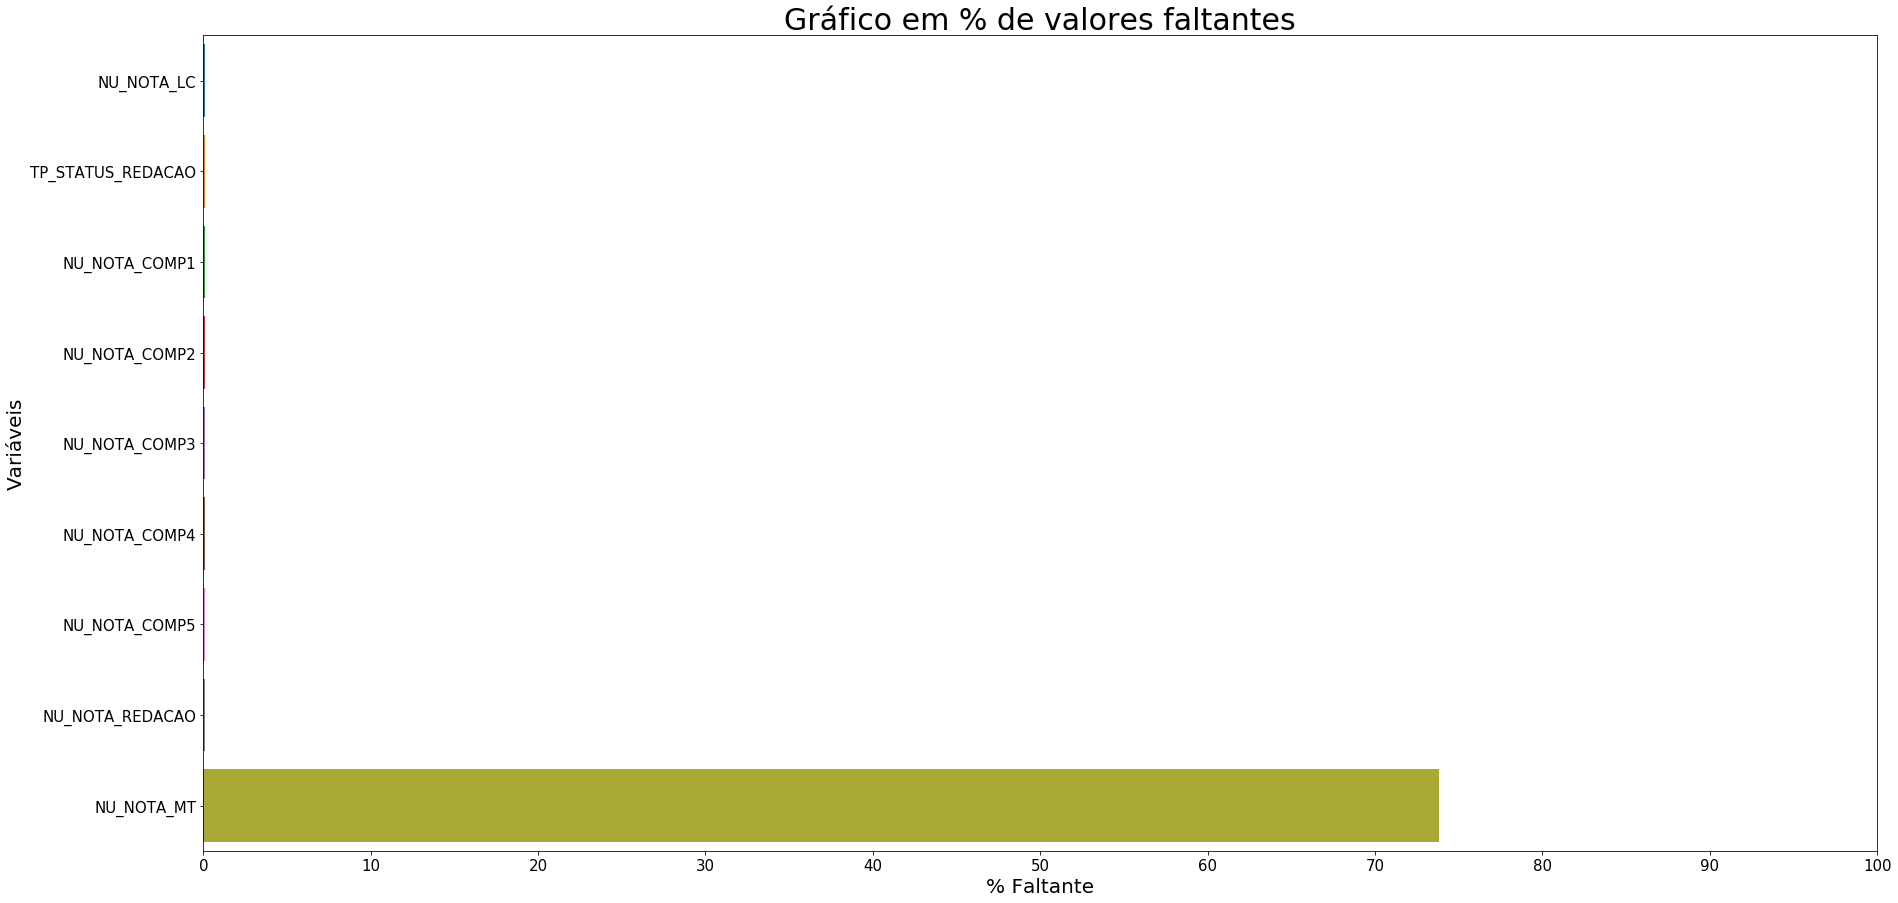

In [31]:
# Gráfico de NaN para teste
plot_nan_porcentagem_por_coluna(test)

Ainda temos alguns valores faltantes nas notas. Vamos ver em foco essas amostras e avaliar se conseguimos extrair alguma conclusão do **motivo de estar faltando informação**:

In [32]:
# Avaliando as amostras ainda faltante
test.loc[pd.isna(test['NU_NOTA_REDACAO']) == True,notas_segundo_dia+['TP_PRESENCA_LC','TP_STATUS_REDACAO','NU_NOTA_MT']]

,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,NU_NOTA_LC,TP_PRESENCA_LC,TP_STATUS_REDACAO,NU_NOTA_MT
1239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,0.0
2302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,0.0
2593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,0.0
3875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,0.0


Esse resultado mostra que os valores faltantes são relacionados aos alunos que foram eliminado de alguma forma da prova. Isso nos leva a próxima etapa...
#### (2.3.2) Quem foi eliminado na prova de acordo as variáveis `TP_PRESENCA` receberá zero nas provas
`NU_NOTA_MT` foi imputada segundo essa regra na etapa 2.1

In [33]:
# Realizar a imputação de zeros para as provas do segundo dia
test.loc[test['TP_PRESENCA_LC'] == 2, notas_segundo_dia] = 0.0

In [34]:
# Realizar o mesmo para TP_STATUS_REDACAO (4 significa em texto em branco)
test.loc[test['TP_PRESENCA_LC'] == 2, 'TP_STATUS_REDACAO'] = 4

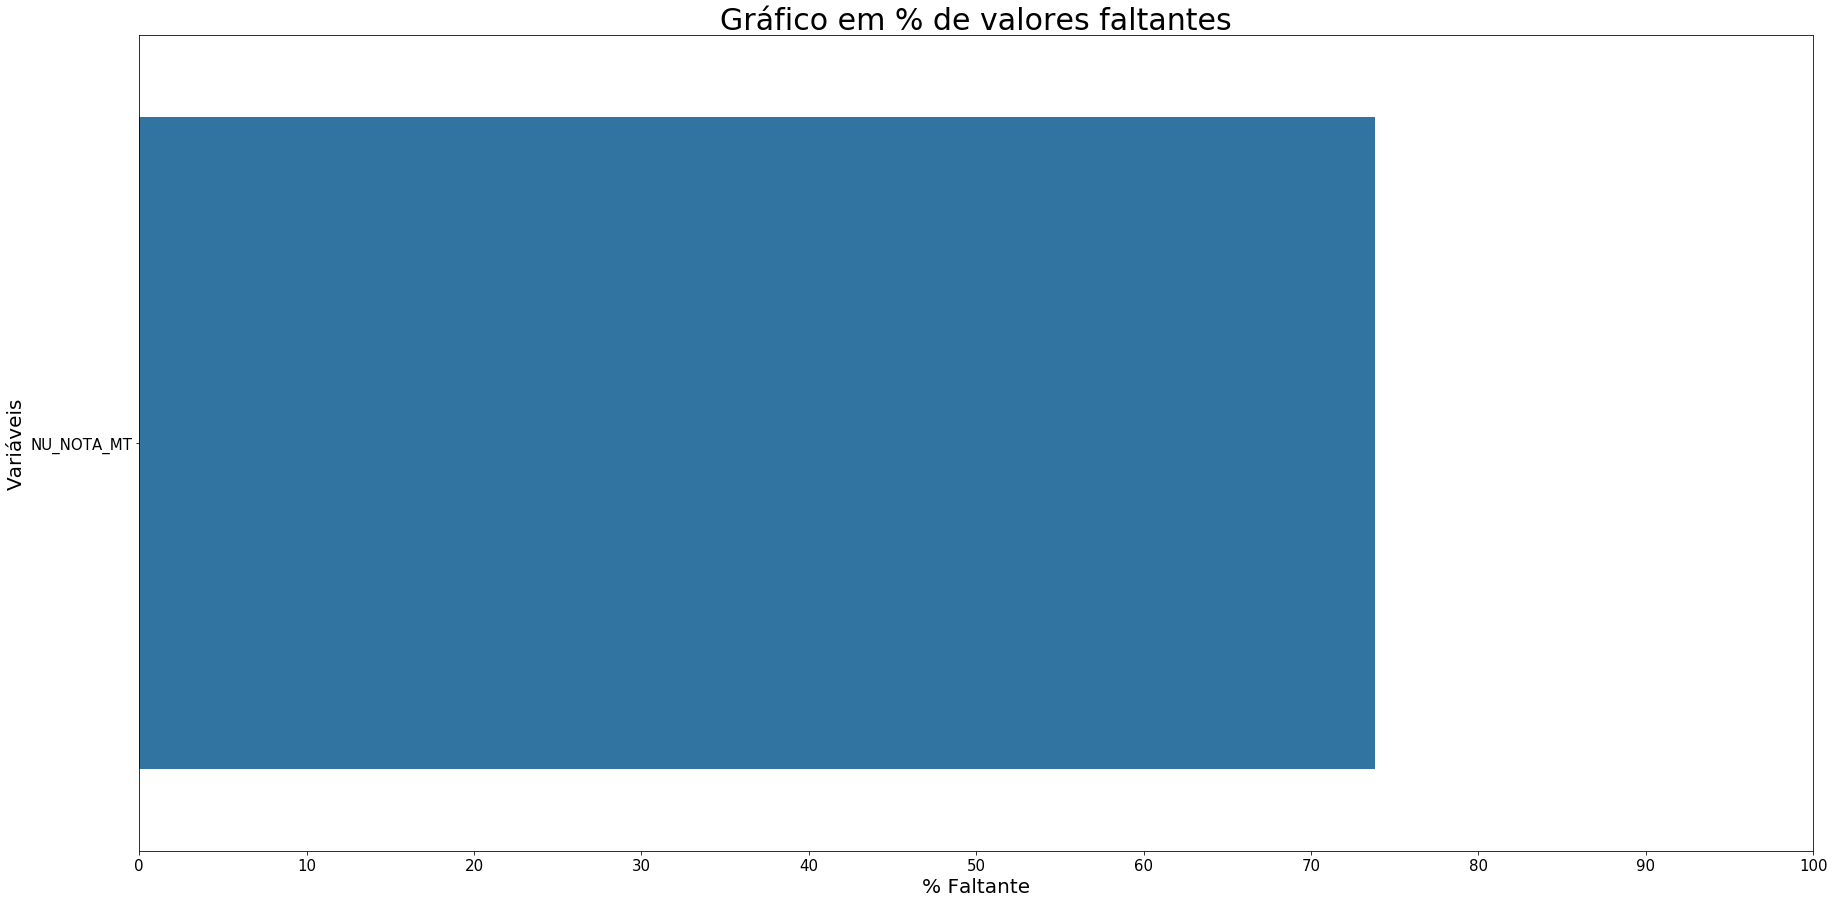

In [35]:
# Revisando o gráfico de valores faltantes
plot_nan_porcentagem_por_coluna(test)

### Comentário
Assim eliminamos os valores faltantes sem a necessidade de qualquer ferramenta matemática: os dados falaram exatamente porque temos aqueles valores faltantes. Além disso com uma análise visual em cima das informações, conseguimos realizar pelo menos ~35% do desafio de forma correta! Isso mostra a importância e necessidade de entender os dados antes de partir para qualquer modelagem.

# Eliminar colunas da base de dados que contém informações espúrias para o objetivo
Aqui serão removidas as colunas que o cientista (eu) considera irrelevante para o objetivo do desafio:

**OBS**: `NU_NOTA_COMPx` onde `x` varia de 1 a 5 foram removidas, pois elas compõe no geral uma nota maior: `NU_NOTA_REDACAO`.

In [36]:
# Colunas para limpar
cols_to_remove = ['SG_UF_RESIDENCIA','CO_UF_RESIDENCIA','TP_ANO_CONCLUIU',
                  'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT',
                  'TP_LINGUA','TP_STATUS_REDACAO','TP_PRESENCA_CN','TP_PRESENCA_CH','TP_PRESENCA_LC',
                  'NU_NOTA_COMP1', 'NU_NOTA_COMP2','NU_NOTA_COMP3','NU_NOTA_COMP4','NU_NOTA_COMP5']

In [37]:
# Remover colunas
train.drop(axis=1, columns=cols_to_remove, inplace=True)
test.drop(axis=1, columns=cols_to_remove, inplace=True)

In [38]:
# Remover do conjunto de treinamento o numero de inscrição (não serve como feature)
train.drop(axis=1, columns=['NU_INSCRICAO'], inplace=True)

In [39]:
# Visualizando o conjunto de treinamento
train.head(5)

,NU_NOTA_MT,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ESCOLA,IN_TREINEIRO,IN_BAIXA_VISAO,IN_CEGUEIRA,...,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q047
0,399.4,24,M,1,1,1,1,0,0,0,...,495.4,581.2,520.0,D,D,C,A,A,C,A
1,459.8,17,F,3,1,2,2,0,0,0,...,544.1,599.0,580.0,A,A,B,A,A,A,A
2,364.5,18,F,1,1,1,1,0,0,0,...,583.2,410.9,620.0,E,E,C,B,B,A,A
3,529.2,18,F,3,1,2,2,0,0,0,...,604.2,484.5,560.0,E,D,C,B,B,C,A
4,566.7,18,F,1,1,1,1,0,0,0,...,625.8,611.2,620.0,G,F,L,B,B,A,D


In [40]:
# Visualizando o conjunto de treinamento
test.head(5)

,NU_INSCRICAO,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ESCOLA,IN_TREINEIRO,IN_BAIXA_VISAO,IN_CEGUEIRA,...,NU_NOTA_LC,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q047,NU_NOTA_MT
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,22,F,3,1,1,1,0,0,0,...,431.8,420.0,B,A,C,A,A,C,A,NaN
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,26,F,3,1,1,1,0,0,0,...,548.0,580.0,E,B,C,B,B,B,A,NaN
2,b38a03232f43b11c9d0788abaf060f7366053b6d,21,M,1,1,2,2,0,0,0,...,613.6,320.0,E,E,D,B,B,A,A,NaN
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,27,F,3,1,1,1,0,0,0,...,0.0,0.0,H,E,G,B,B,A,A,0.0
4,715494628a50142ce8cb17191cfe6d0f3cae0934,18,M,1,1,2,2,0,0,0,...,571.4,320.0,D,H,H,C,B,A,A,NaN


# Modelagem - Usando apenas as notas, qual o resultado predito?

A partir do conhecimento adquirido no inicio com o desafio, será gerado modelos usando apenas as preditoras que dão certo: `NU_NOTA`.

O procedimento para modelagem consta de uma optimização bayesiana Validação Cruzada *10-Folds* para Random Forest Regressor e Support Vector Machine Regressor, buscando os melhores hiper parâmetros. Ao final será avaliado o **R2 Score** para definir o melhor modelo.

## Preparar conjunto de dados

Usando apenas as notas:

In [41]:
# Datasets
df_train = train[['NU_NOTA_CN', 'NU_NOTA_CH','NU_NOTA_LC', 'NU_NOTA_REDACAO','NU_NOTA_MT']].copy()
df_test = test[['NU_NOTA_CN', 'NU_NOTA_CH','NU_NOTA_LC', 'NU_NOTA_REDACAO','NU_NOTA_MT','NU_INSCRICAO']].copy()

In [42]:
# Definir conjunto de treino e teste com divisão XY
x_train = df_train.drop(columns=['NU_NOTA_MT'],axis=1)
y_train = df_train['NU_NOTA_MT']

## Aplicar padronização

In [43]:
# Criar instancia
std_scaler = StandardScaler().fit(x_train)

In [44]:
# Aplicar
x_train = std_scaler.transform(x_train)

Conjunto de teste será preparado na etapa de predição, pois ele tem a particularidade referente ao número de inscrição.

## Definir funções para auxiliar na busca dos hiper parâmetros

In [45]:
def printModelGeneralInfo(model, hp, score, metric_evaluated):
    print('##############################################################')
    print('Model:', type(model).__name__)
    print('Metric: ', metric_evaluated, ' | Score: ', round(score,5))
    print('Best Parameters: ', hp)
    print('##############################################################\n')

In [46]:
def optimizationBayesCV(model_estimator, params, metric_to_eval, n_iter, x, y):
    """
    Author: Kaike W. Reis
    Function to evaluate the best set of HP given a specific metric using Bayes Optimization Search CV.
    Arguments:
        model_estimator: Model to be evaluated
        params: hyper parameters grid
        metric_to_eval: metric to be evaluated in the search (model evaluation)
        n_iter: iterations in BayesSearchCV
        features: x train set to be used
        target: y train set to be used
    Returns:
        (best_model, best_hiperparameters, best_metric_score)
    """
    # Define Search CV object
    hp_search = BayesSearchCV(estimator=model_estimator,
                              search_spaces=params,
                              n_iter=n_iter,
                              cv=5,
                              scoring=metric_to_eval,
                              verbose=0,
                              random_state=101,
                              n_jobs=5,
                              n_points=5)
    # Search
    hp_search.fit(x, y)
    # Finish
    return (hp_search.best_estimator_, hp_search.best_params_, hp_search.best_score_)

In [47]:
def optimizationPipeline(estimator,params,x_train,y_train,metric_eval,n_iter=None):
    """
    Author: Kaike W. Reis
    Function to apply a specific HP optimization and present results.
    Arguments:
        estimator: Model to be evaluated
        params: hyper parameters grid
        x_train: self explanatory
        y_train: self explanatory
        metric_to_eval: metric to be evaluated in the search (model evaluation)
        n_iter: iterations in RandomSearchCV or BayesOptimization. It's ignored if opt_option is 'grid'.
    Returns:
        dictionary with overall results
    """  
    # Search
    best_model,best_params,best_score = optimizationBayesCV(estimator,params,metric_eval,n_iter,x_train,y_train)
    
    # Wait for results
    sleep(1.5)  
    
    # Show Model Results
    printModelGeneralInfo(best_model, best_params, best_score, metric_eval)
    
    # Returns
    returned_dict = {'best_model':best_model,'best_params':best_params,'best_score':best_score,'metric_used':metric_eval}
    return returned_dict

## Fazer busca dos melhores HP

### Random Forest Regressor

In [51]:
# Definir estimador
modelo = RandomForestRegressor(random_state=1206, criterion='mse', warm_start=True)

# Definir o grid de parâmetros
params = {'n_estimators': Integer(100, 500, prior='uniform'),
          'max_depth': Integer(2, 32, prior='uniform'),
          'min_samples_split': Integer(2, 16, prior='uniform'),
          'min_samples_leaf': Integer(1, 8, prior='uniform'),
          'max_features': Categorical(['sqrt','log2','auto'], transform='onehot')}

# HP Optimization
rfr_modelo = optimizationPipeline(modelo,params,x_train,y_train,'neg_mean_absolute_error',n_iter=50)

##############################################################
Model: RandomForestRegressor
Metric:  neg_mean_absolute_error  | Score:  -58.64187
Best Parameters:  OrderedDict([('max_depth', 5), ('max_features', 'auto'), ('min_samples_leaf', 8), ('min_samples_split', 15), ('n_estimators', 402)])
##############################################################



## Testando alguns modelos lineares ...

### Linear Regression

In [53]:
# Fit modelo linear
lrg_modelo = LinearRegression().fit(x_train, y_train)
# Realizar predição no conjunto de treinamento
y_pred = lrg_modelo.predict(x_train)

### Ridge Regression

In [54]:
# Definir estimador
modelo = Ridge(random_state=1206)

# Definir o grid de parâmetros
params = {'alpha': Real(1e-3, 10, prior='log-uniform')}

# HP Optimization
rdg_modelo = optimizationPipeline(modelo,params,x_train,y_train,'neg_mean_absolute_error',n_iter=50)

##############################################################
Model: Ridge
Metric:  neg_mean_absolute_error  | Score:  -62.27118
Best Parameters:  OrderedDict([('alpha', 0.001)])
##############################################################



## Avaliando o R2 Score para os modelos
OBS: Quanto mais próximo de um, melhor será o modelo. Vale ressaltar que o modelo linear configura como um baseline, pois é o modelo mais simples.

In [55]:
print('R2 Score para Random Forest: ',round(r2_score(y_train, rfr_modelo['best_model'].predict(x_train)), 3))
print('R2 Score para Ridge Regression: ',round(r2_score(y_train, rdg_modelo['best_model'].predict(x_train)), 3))
print('R2 Score para Linear Regression: ',round(r2_score(y_train, lrg_modelo.predict(x_train)), 3))

R2 Score para Random Forest:  0.465
R2 Score para Ridge Regression:  0.364
R2 Score para Linear Regression:  0.364


### Comentários
Usando Bayes Optimization para o conjunto de treinamento foram avalidas o R2 Score. O modelo com R2 Score mais alto será usado para realizar as predições. Note que a random forest apresenta um maior R2 e portanto será considerado ele para realizar as predições futuras.

## Visualização dos resultados de regressão

### Realizar predição com o modelo escolhido

In [71]:
# Definir modelo
modelo_ml = rfr_modelo['best_model']

In [72]:
# Predicao
y_pred_train = modelo_ml.predict(x_train)

### Plot de distribuição dos resíduos

In [73]:
# Calcular os resíduos
y_residuos = y_train - y_pred_train

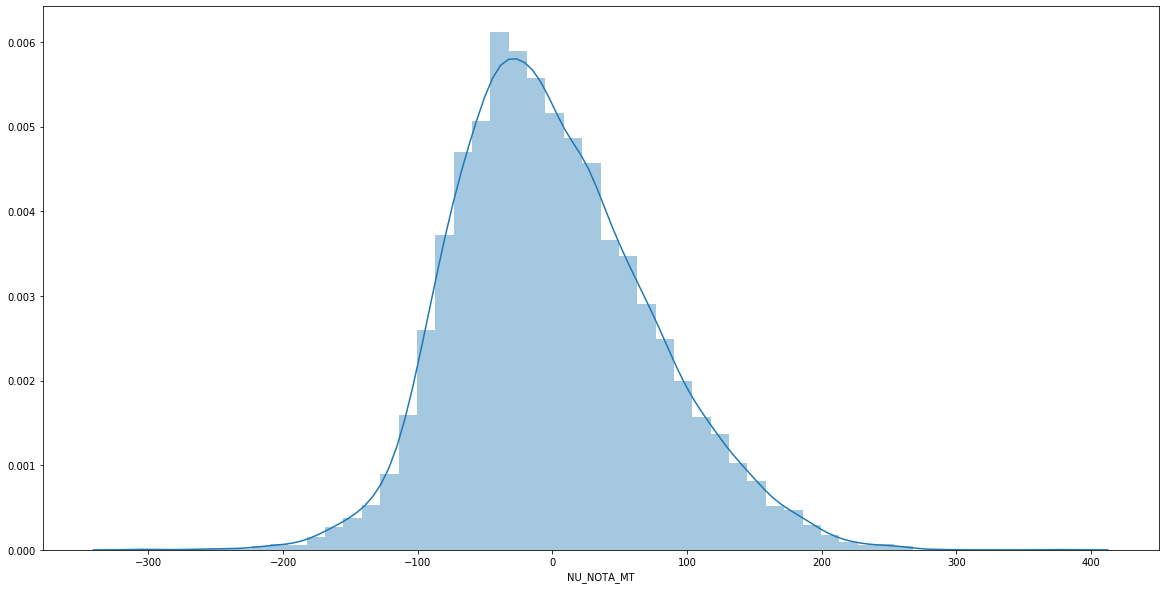

In [74]:
# Fazer plot da distribuição
plt.figure(figsize=(20,10))
sns.distplot(y_residuos);

In [75]:
# Avaliar se a curva resíduos segue uma normal
stats.normaltest(y_residuos)[1] >= 0.05

False

Apesar da curva aparentar uma normal, segundo o teste estatístico ela não é uma normal! O que pode ser um ponto negativo.
### Plot XY do valor predito para o valor real

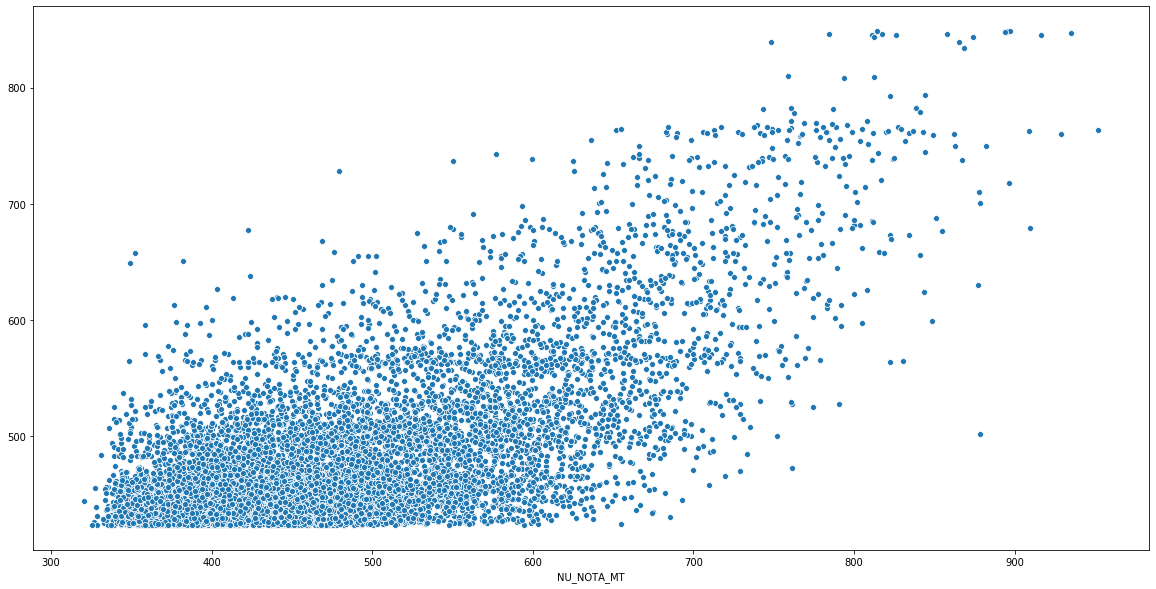

In [77]:
plt.figure(figsize=(20,10))
sns.scatterplot(y_train, y_pred_train);

### Comentário
A partir desses resultados, considero que a minha modelagem não é uma das melhores. Porém seu resultado final fica em torno de 93%...

## Gerando a resposta ...

In [78]:
# Fazer copia do conjunto de teste
answer = df_test.copy()
# Visualizar dataframe de resposta
answer.head(3)

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_REDACAO,NU_NOTA_MT,NU_INSCRICAO
0,464.8,443.5,431.8,420.0,NaN,73ff9fcc02f0a99919906c942c2e1a1042cdcf98
1,391.1,491.1,548.0,580.0,NaN,71a95f9f1b91a82c65ad94abbdf9f54e6066f968
2,595.9,622.7,613.6,320.0,NaN,b38a03232f43b11c9d0788abaf060f7366053b6d


In [79]:
# Pegar conjunto x de teste
x_test = answer[pd.isnull(answer['NU_NOTA_MT'])].drop(axis=1,columns=['NU_INSCRICAO','NU_NOTA_MT'])

# Aplicar padronizacao
x_test = std_scaler.transform(x_test)

In [80]:
# Inserir a predicao no conjunto resposta
answer.loc[pd.isnull(answer['NU_NOTA_MT']), 'NU_NOTA_MT'] = modelo_ml.predict(x_test)

In [81]:
# Salvar resultado
answer[['NU_INSCRICAO','NU_NOTA_MT']].to_csv('answer.csv', index=False)

A resposta final desse modelo, analisando o review da codenation foi de **93.51%**.